# PCAP Malware Detection using ML

welcome to this novel framework designed to test the efficiency of machine learning classifiers in detecting infected packets in a pcap. this goal is achieved by splitting the framework into 3 main sections. 

The first section focuses on reading in the pcap, converting it to a Pandas DataFrame and saving it to disk as a binary pickle file.

The second section consists of the test-train split method, different ML classifiers and their metrics. 

The third section consists of a testing script designed to run the differnt classifiers in a loop at the end of which their accuracies are plotted on a graph

# Section 1

In [ ]:
from scapy.all import *

#change the file path here to read in the desired pcap
Pcap=rdpcap("E:/YEAR 3/FYP/QakBot/1/2020-01-29-Qbot-bot.pcap")

print(Pcap)

# Scapy to Pandas conversion and Pickling

In [ ]:
#code from https://github.com/secdevopsai/Packet-Analytics/blob/master/Packet-Analytics.ipynb
#code from https://github.com/secdevopsai/Packet-Analytics/blob/master/Packet-Analytics.ipynb
#code from https://github.com/secdevopsai/Packet-Analytics/blob/master/Packet-Analytics.ipynb
from tqdm import tqdm_notebook as tqdm

import pandas as pd #used for dataframes
import numpy as np #used for ml
import binascii # Binary to Ascii, used in pcap to df
import pickle


# Collect field names from IP/TCP/UDP (These will be columns in DF)
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

fcount=len(dataframe_fields)

#prints the number of available features
print("There are currently",fcount,"features available")

# Create blank DataFrame
df = pd.DataFrame(columns=dataframe_fields)
for packet in tqdm(Pcap[IP]):
    # Field array for each row of DataFrame
    field_values = []
    # Add all IP fields to dataframe
    for field in ip_fields:
        if field == 'options':
            # Retrieving number of options defined in IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Append payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Add row to DF
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.shape)

# Return first 5 rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.head())

# Return last 5 rows
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df.tail())

#end of code from https://github.com/secdevopsai/Packet-Analytics/blob/master/Packet-Analytics.ipynb
#end of code from https://github.com/secdevopsai/Packet-Analytics/blob/master/Packet-Analytics.ipynb
#end of code from https://github.com/secdevopsai/Packet-Analytics/blob/master/Packet-Analytics.ipynb


#add identifier for packets, 0 for normal, 1 for Qbot & 2 for emotet
df['class']='0'

#df to pickle, saved to the working directory by default. 
#can be changed to required save path
df.to_pickle("./test.pkl")

### PCAP scatter plot showing malware activity over time

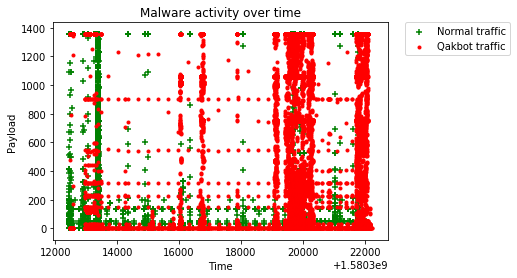

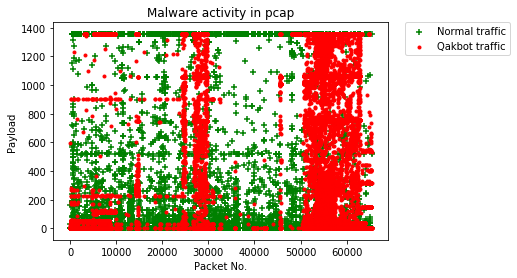

In [2]:
from matplotlib import pyplot as plt

import pandas as pd
import pickle

df1=pd.read_pickle("./2020-01-29-Qbot-clean.pkl")
df2=pd.read_pickle("./2020-01-29-Qbot-bot.pkl")
#print(len(df1))
#print(len(df2))

plt.title("Malware activity over time")
plt.xlabel('Time')
plt.ylabel('Payload')
plt.scatter(df1['time'],df1['payload'],color='green',marker='+',label='Normal traffic')
plt.scatter(df2['time'],df2['payload'],color='red',marker='.',label='Qakbot traffic')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

plt.title("Malware activity in pcap")
plt.xlabel('Packet No.')
plt.ylabel('Payload')
plt.scatter(df1['id'],df1['payload'],color='green',marker='+',label='Normal traffic')
plt.scatter(df2['id'],df2['payload'],color='red',marker='.',label='Qakbot traffic')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Section 2

# Data Test-Train splitting

In [3]:
from sklearn.model_selection import train_test_split

import pandas as pd #used for dataframes
import pickle

#change the file path here to choose different dataset
norm=pd.read_pickle("./2020-01-29-Qbot-clean.pkl")
bot=pd.read_pickle("./2020-01-29-Qbot-bot.pkl")

#bot2=pd.read_pickle("./2018-12-14-Emotet-infection-with-Qakbot-emo.pkl")

#print(norm)
#print(bot)

temp=pd.concat([norm,bot])

#temp2=pd.concat([temp,bot2])

final=temp.sample(frac=1).reset_index(drop=True)


#test-train split, change test_size to change size of the splits
train, test = train_test_split(final, test_size = 0.50)

print("Training size: {}".format(len(train)))
print("Test size: {}".format(len(test)))

#features used for classification
features = ["ttl","id","payload"]

#training dataset
X_train = train[features]
Y_train = train["class"]

#testing dataset
X_test = test[features]
Y_test = test["class"]

Training size: 37202
Test size: 37202


# Machine Learning Classifiers

## Random Forest Classifier

In [4]:
%%time
import warnings #only used to get rid of annoying future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import RandomForestClassifier

#classifier intialisation
rfc=RandomForestClassifier()

#classifier training
rfc.fit(X_train, Y_train)

#classifier testing
Y_Pred=rfc.predict(X_test)

Wall time: 246 ms


In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("Random Forest Classifier",'\n')

#accuracy metric
score = accuracy_score(Y_test,Y_Pred)*100
print("Accuracy:",round(score,2),"%",'\n')

#confusion metric, calculate TP,FP,TN and FN
print("Confusion matrix")
print(confusion_matrix(Y_test,Y_Pred),'\n')

#report containing precision, recall and f1-score
print("Classification report")
print(classification_report(Y_test,Y_Pred))

Random Forest Classifier 

Accuracy: 98.51 % 

Confusion matrix
[[13328   292]
 [  264 23318]] 

Classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13620
           1       0.99      0.99      0.99     23582

    accuracy                           0.99     37202
   macro avg       0.98      0.98      0.98     37202
weighted avg       0.99      0.99      0.99     37202



## Decision Tree Classifier

In [6]:
%%time
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

#classifier intialisation
dtc = DecisionTreeClassifier(min_samples_split=1000)

#Training
DT = dtc.fit(X_train, Y_train)

#testing
Y_Pred=DT.predict(X_test)


Wall time: 61.6 ms


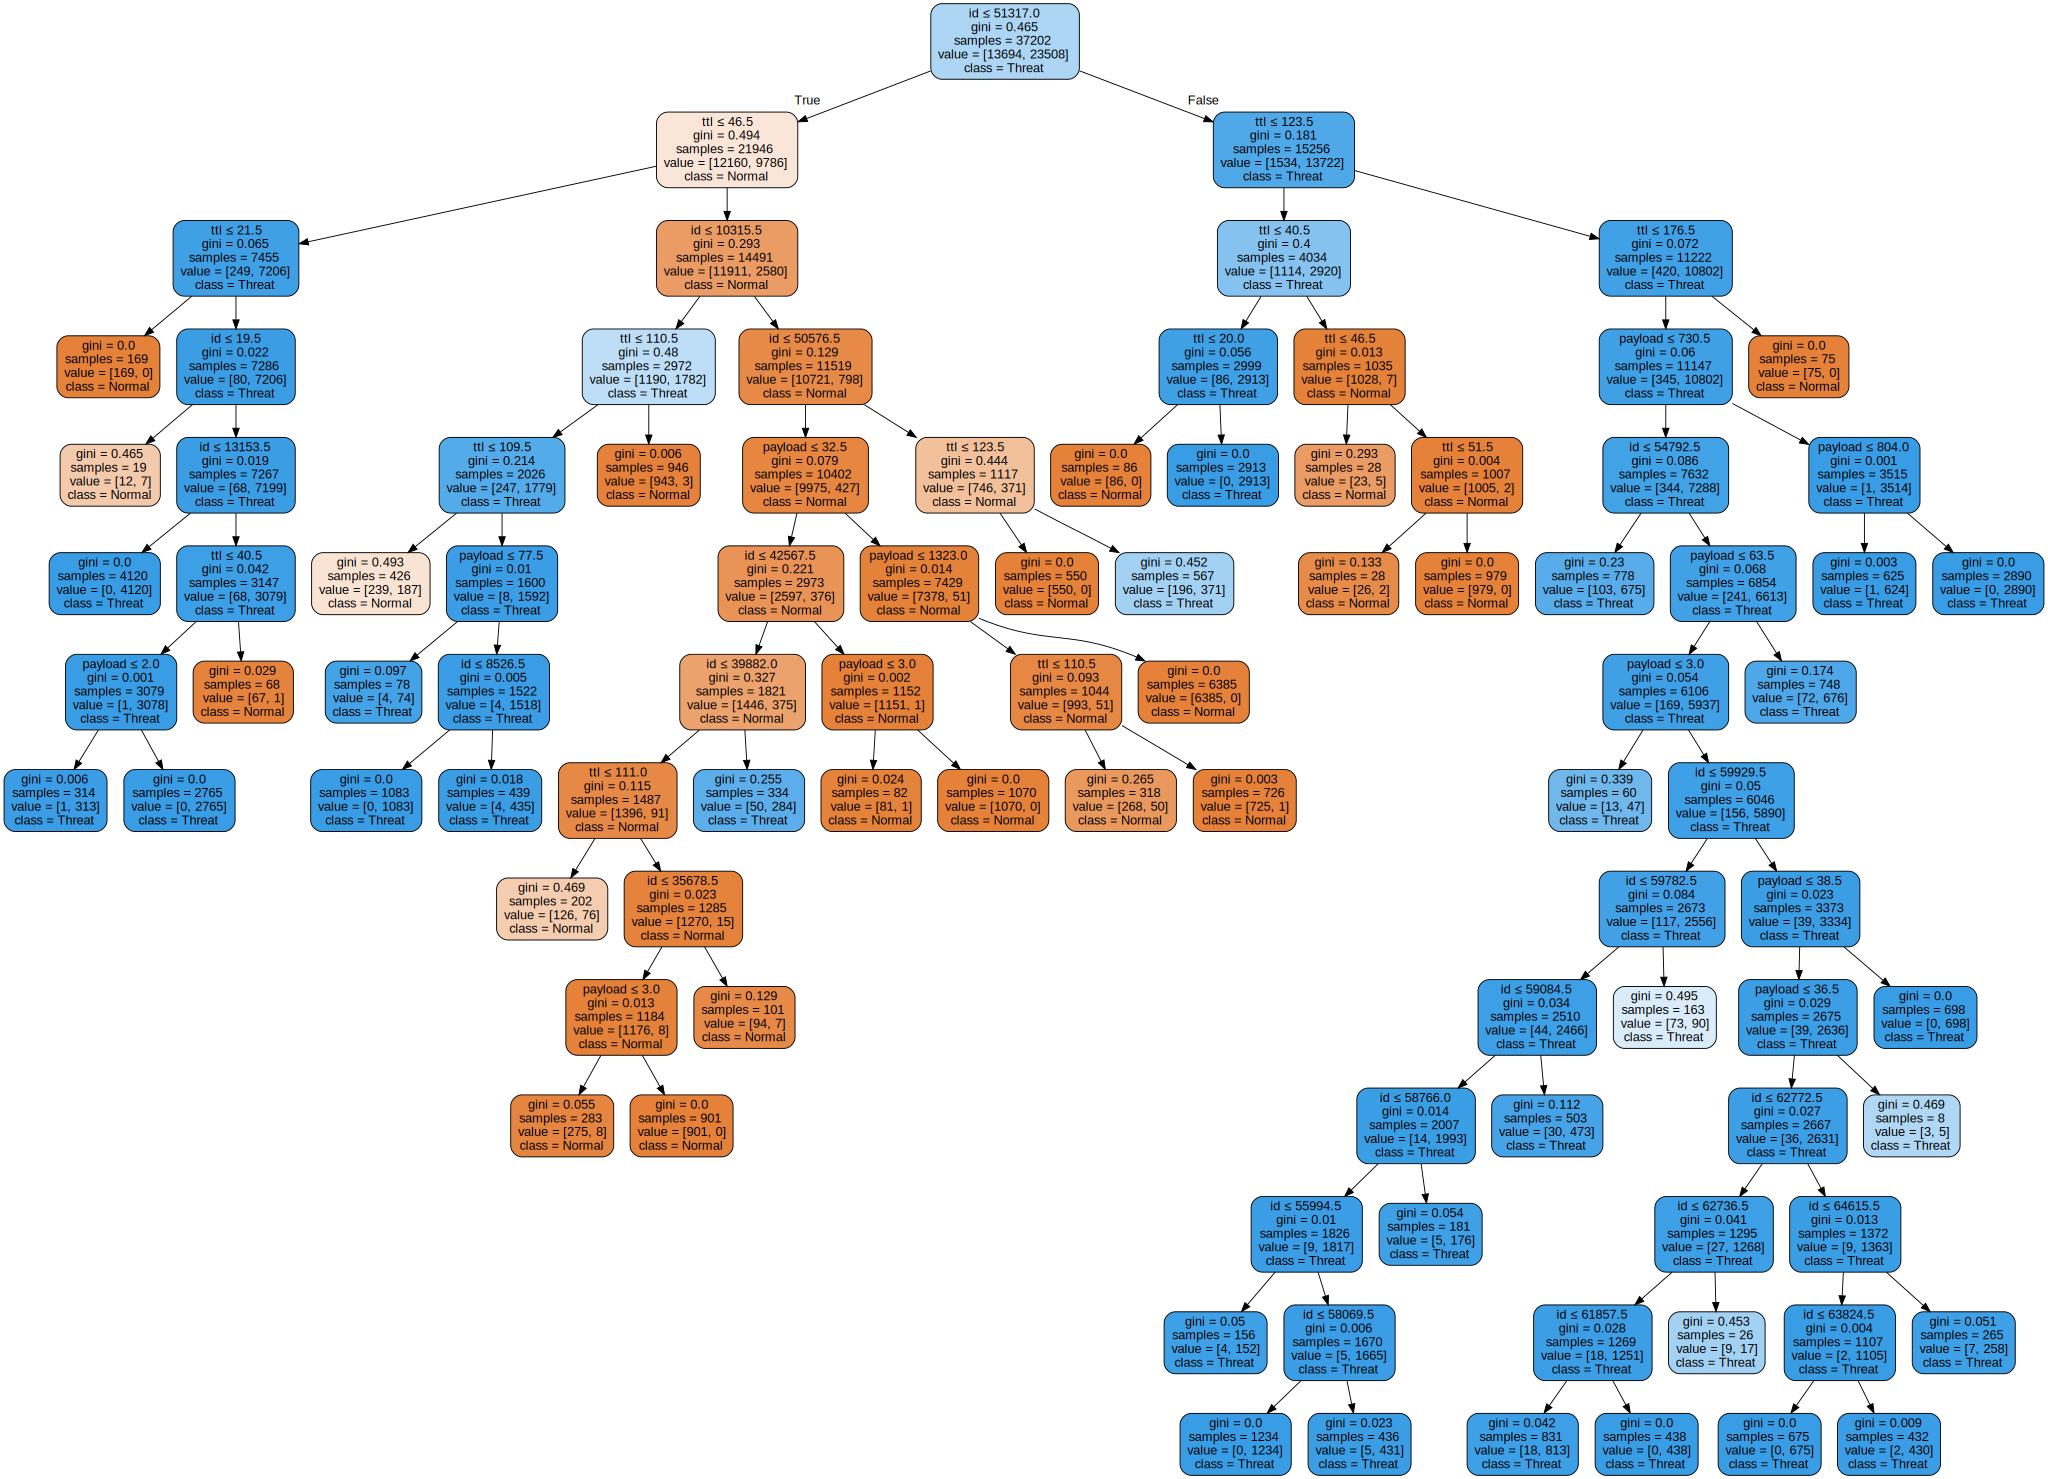

In [7]:
#function to print decision tree
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

class_names=["Normal", "Threat"]

model = tree.export_graphviz(DT, 
                  feature_names=features,  
                  class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(model)

graph

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("Decision Tree Classifier",'\n')

#accuracy metric
score = accuracy_score(Y_test,Y_Pred)*100
print("Accuracy:",round(score,2),"%",'\n')

#confusion metric, calculate TP,FP,TN and FN
print("Confusion matrix")
print(confusion_matrix(Y_test,Y_Pred),'\n')

#report containing precision, recall and f1-score
print("Classification report")
print(classification_report(Y_test,Y_Pred))

Decision Tree Classifier 

Accuracy: 97.42 % 

Confusion matrix
[[13003   617]
 [  344 23238]] 

Classification report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     13620
           1       0.97      0.99      0.98     23582

    accuracy                           0.97     37202
   macro avg       0.97      0.97      0.97     37202
weighted avg       0.97      0.97      0.97     37202



## K-Nearest Neighbour Classifier 

In [9]:
%%time
from sklearn.neighbors import KNeighborsClassifier

#intialiser
knn=KNeighborsClassifier()

#training
knn.fit(X_train,Y_train)

#testing
Y_Pred=knn.predict(X_test)

Wall time: 743 ms


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("K-Nearest Neighbour classifier",'\n')

#accuracy metric
score = accuracy_score(Y_test,Y_Pred)*100
print("Accuracy:",round(score,2),"%",'\n')

#confusion metric, calculate TP,FP,TN and FN
print("Confusion matrix")
print(confusion_matrix(Y_test,Y_Pred),'\n')

#report containing precision, recall and f1-score
print("Classification report")
print(classification_report(Y_test,Y_Pred))

K-Nearest Neighbour classifier 

Accuracy: 96.91 % 

Confusion matrix
[[12955   665]
 [  483 23099]] 

Classification report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     13620
           1       0.97      0.98      0.98     23582

    accuracy                           0.97     37202
   macro avg       0.97      0.97      0.97     37202
weighted avg       0.97      0.97      0.97     37202



## Logistic Regression

In [11]:
%%time
import warnings #only used to get rid of annoying future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import LogisticRegression

#intialisation
lrc=LogisticRegression()

#training
lrc.fit(X_train,Y_train)

#testing
Y_Pred=lrc.predict(X_test)


Wall time: 65.8 ms


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("Logistic Regression Classifier",'\n')

#accuracy metric
score = accuracy_score(Y_test,Y_Pred)*100
print("Accuracy:",round(score,2),"%",'\n')

#confusion metric, calculate TP,FP,TN and FN
print("Confusion matrix")
print(confusion_matrix(Y_test,Y_Pred),'\n')

#report containing precision, recall and f1-score
print("Classification report")
print(classification_report(Y_test,Y_Pred))

Logistic Regression Classifier 

Accuracy: 65.36 % 

Confusion matrix
[[ 3456 10164]
 [ 2722 20860]] 

Classification report
              precision    recall  f1-score   support

           0       0.56      0.25      0.35     13620
           1       0.67      0.88      0.76     23582

    accuracy                           0.65     37202
   macro avg       0.62      0.57      0.56     37202
weighted avg       0.63      0.65      0.61     37202



## SVM Classifier

In [13]:
%%time
from sklearn.svm import SVC

#intialisation
svmc=SVC(gamma='auto')

#training
svmc=svmc.fit(X_train,Y_train)

#testing
Y_Pred=svmc.predict(X_test)

Wall time: 5min 44s


In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("SVM Classifier",'\n')

#accuracy metric
score = accuracy_score(Y_test,Y_Pred)*100
print("Accuracy:",round(score,2),"%",'\n')

#confusion metric, calculate TP,FP,TN and FN
print("Confusion matrix")
print(confusion_matrix(Y_test,Y_Pred),'\n')

#report containing precision, recall and f1-score
print("Classification report")
print(classification_report(Y_test,Y_Pred))

SVM Classifier 

Accuracy: 86.87 % 

Confusion matrix
[[ 8891  4729]
 [  155 23427]] 

Classification report
              precision    recall  f1-score   support

           0       0.98      0.65      0.78     13620
           1       0.83      0.99      0.91     23582

    accuracy                           0.87     37202
   macro avg       0.91      0.82      0.85     37202
weighted avg       0.89      0.87      0.86     37202



## Neural Network Classifier

In [15]:
%%time
from sklearn.neural_network import MLPClassifier

nn=MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(100,100),random_state=1,max_iter=300)

nn.fit(X_train,Y_train)

Y_Pred=nn.predict(X_test)

score = accuracy_score(Y_test,Y_Pred)*100

Wall time: 36.7 s


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("Neural Network Classifier",'\n')

#accuracy metric
score = accuracy_score(Y_test,Y_Pred)*100
print("Accuracy:",round(score,2),"%",'\n')

#confusion metric, calculate TP,FP,TN and FN
print("Confusion matrix")
print(confusion_matrix(Y_test,Y_Pred),'\n')

#report containing precision, recall and f1-score
print("Classification report")
print(classification_report(Y_test,Y_Pred))

Neural Network Classifier 

Accuracy: 83.82 % 

Confusion matrix
[[11159  2461]
 [ 3557 20025]] 

Classification report
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     13620
           1       0.89      0.85      0.87     23582

    accuracy                           0.84     37202
   macro avg       0.82      0.83      0.83     37202
weighted avg       0.84      0.84      0.84     37202



# Final Testing Script

This section of the script is used to check calssifier accuracy over a number of runs with different test/train datasets.

for the final testing, the SVM classifier was avoided due to its extremely high run time. Logistic regression was removed due to its poor accuracy.

In [17]:
%%time
import warnings #only used to get rid of annoying future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd #used for dataframes
import pickle

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

#change file path here to chose different datasets
cl=pd.read_pickle("./2020-01-29-Qbot-clean.pkl")
dr=pd.read_pickle("./2020-01-29-Qbot-bot.pkl")

#print(cl)
#print(dr)

temp=pd.concat([cl,dr])

final=temp.sample(frac=1).reset_index(drop=True)

final

#features used
features = ["ttl","id","payload"]

X=[]
Y=[]

dtc = DecisionTreeClassifier(min_samples_split=1000)
rfc=RandomForestClassifier()
knn=KNeighborsClassifier()
# lrc=LogisticRegression()
# nn=MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(100,100),random_state=1,max_iter=300)

X=[]
hs=0
hc=[]
dtca=[]
rfca=[]
knca=[]
# lrca=[]
nnca=[]

for x in tqdm(range(10)):
    
    train, test = train_test_split(final, test_size = 0.50)

    X_train = train[features]
    Y_train = train["class"]

    X_test = test[features]
    Y_test = test["class"]

    dtc.fit(X_train, Y_train)
    Y_Pred=dtc.predict(X_test)
    score = accuracy_score(Y_test,Y_Pred)*100   
    dtca.append(score)
    if score > hs:
        hs=round(score,2)
        hc='Decision Tree Classifier'
    
    
    rfc.fit(X_train, Y_train)
    Y_Pred=rfc.predict(X_test)
    score = accuracy_score(Y_test,Y_Pred)*100   
    rfca.append(score)
    if score > hs:
        hs=round(score,2)
        hc='Random Forest Classifier'
    
    knn.fit(X_train,Y_train)
    Y_Pred=knn.predict(X_test)
    score = accuracy_score(Y_test,Y_Pred)*100   
    knca.append(score)
    if score > hs:
        hs=round(score,2)
        hc='K-Nearest Neighbour'
    
#     nn.fit(X_train,Y_train)
#     Y_Pred=nn.predict(X_test)
#     score = accuracy_score(Y_test,Y_Pred)*100
#     nnca.append(score)
#     if score > hs:
#         hs=round(score,2)
#         hc='Neural Network'

#     lrc.fit(X_train,Y_train)
#     Y_Pred=lrc.predict(X_test)
#     score = accuracy_score(Y_test,Y_Pred)*100   
#     lrca.append(score)
#     if score > hs:
#         hs=round(score,2)
#         hc='Linear Regression'
    
    X.append(x)
    
print("Features used",features,'\n')
print("Highest accuracy:",hs)
print("Classifier:",hc,'\n')


Features used ['ttl', 'id', 'payload'] 

Highest accuracy: 98.59
Classifier: Random Forest Classifier 

Wall time: 14 s


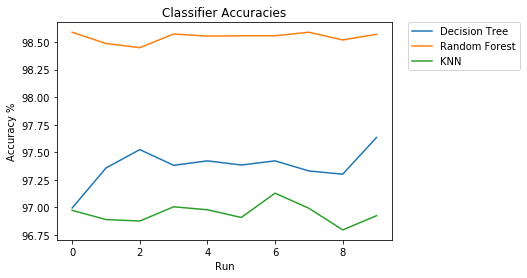

In [18]:
plt.plot(X,dtca,label='Decision Tree')
plt.plot(X,rfca,label='Random Forest')
plt.plot(X,knca,label='KNN')
#plt.plot(X,lrca,label='Logistic Regression')
#plt.plot(X,nnca,label='Neural Network')
plt.title("Classifier Accuracies")
plt.xlabel("Run")
plt.ylabel("Accuracy %")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()